In [1]:
import pandas as pd

In [2]:

df = pd.read_csv('iter.csv')


In [3]:
df


,Refs,Reads
0,ACCATAATGCGTGGGGCCGACCTCGGAATGCGGTCTCCATGCGCGT...,ACCACAATGCGTGGGGCCGACCCGGAATGCGGGTCTCTATGCGCGT...
1,TCGAAGCAGTAGGGCCTACCAAATAGGTTGGTCCTCCGTTGTATCT...,TCGAAGCAGTAGGGCCTACAAATAGGTTGGTCCTCCGTTTGTATCT...
2,AGTTAACGTCCCACGGCGAGGCACTCTTGATCCCCACCTTCAAGAG...,AGTTAACGTCCCACGGCGAGGCACTCTTGATGCCCCACCTTCAAGA...
3,GCCCAAGGGTACGCCCGCAGCGACGCAATTGGCGGAGTAAGCGCGT...,GCCCAAGGGTACGCCCGCAGCGACGCAATTGGCGGAGTAAGCGCGT...
4,GCACTGATGTAACTCATGGTACATCCGTCGCTGAGCGCCATTTTGT...,GCACTGATGTAACTCATGGTACATCCGTCGCTGAGCGCCATTTTTG...
...,...,...
9995,GCATGATTTGGAAGGTCGGCACTATACCCACCCAGGGTATATGGTC...,GCATGATTTGGAAGGTCGGCACTATACCCACCCAGGGTATATGGTC...
9996,GAAGTTTGGAACGTGTTCGTCCGCCAATTAAGGTTGGCTTCTAGTA...,GAACGTTTGGAACGTGTTCGTCCGCCAATTAAGGTTGGCTTCTCAG...
9997,TGCATCCCGGACAACCGCAAGGGTGCATGGGCACCGCAATTCCCAA...,TGCATCCCCGGACAACCGCAAGGGTGCATGGGCACCGCAATTCCCC...
9998,ACTGGACGTCCTATGCTGGCATAATGAAACGACAACCTGTCTTCGA...,ACTGGACGTCCTATGCTGGCATAATGAAACGACAACCTGTCTTCGA...


In [4]:
from tqdm import tqdm


In [5]:
noisy_strands = [s.strip() for s in list(df['Reads'])]


In [6]:
ref_strands = [s.strip() for s in list(df['Refs'])]


In [7]:
import difflib


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import os

# use LaTeX fonts in the plot
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2021basic/bin/universal-darwin'

In [9]:
def print_diff(ref_strand, noisy_strand):
    global pairs
    global pairs_no_pos
    a, b = 0, 0

    # quadratic time, no heuristics
    for match in difflib.SequenceMatcher(None, ref_strand, noisy_strand, autojunk=False).get_matching_blocks():
        was = ref_strand[a:match.a]
        now = noisy_strand[b:match.b]
        
        a = match.a + match.size
        b = match.b + match.size
        
        if was == '' and now == '':
            pass
        else:
            # print('{}|{}'.format(was, now), end=', ')
            pairs += [(was, now, match.a)]
            pairs_no_pos += [(was, now)]



100%|██████████| 10000/10000 [00:00<00:00, 63459.39it/s]


[118, 303, 432, 611, 757, 887, 1029, 1168, 1300, 1407, 1496, 1663, 1751, 1854, 1954, 2080, 2195, 2232, 2362, 2438, 2585, 2683, 2781, 2830, 2885, 2992, 3053, 3147, 3217, 3322, 3321, 3457, 3490, 3538, 3586, 3653, 3802, 3776, 3806, 3933, 3947, 4052, 3944, 4089, 4108, 4108, 4190, 4237, 4231, 4372, 4417, 4349, 4446, 4459, 4556, 4592, 4631, 4708, 4697, 4753, 4912, 4866, 4818, 4881, 5031, 5039, 4984, 5069, 5088, 5081, 5137, 5248, 5243, 5339, 5352, 5384, 5374, 5507, 5538, 5592, 5614, 5607, 5691, 5709, 5789, 5835, 5831, 5895, 6019, 6038, 6035, 6155, 6266, 6257, 6381, 6396, 6400, 6487, 6605, 6648, 6648, 6786, 6910, 6965, 6962, 7105, 7137, 7241, 7362, 7391]


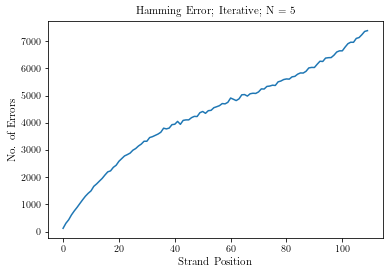

In [10]:
# Hamming Distance Graph
strand_len = 110
count_pos = [0] * (strand_len + 1)

def hamming(ref_strand, recons_strand):
    for i, (c1, c2) in enumerate(zip(ref_strand, recons_strand)):
        if c1 != c2:
            count_pos[i] += 1

for i in tqdm(range(len(ref_strands))):
    hamming(ref_strands[i], noisy_strands[i])

print(count_pos[:-1])
f = plt.figure()
plt.plot(range(strand_len), count_pos[:-1])
plt.title(r'Hamming Error; Iterative; N = 5', fontsize=11)
plt.xlabel(r'Strand Position', fontsize=11)
plt.ylabel(r'No. of Errors', fontsize=11)
plt.show()
f.savefig('cov5-iter-hamming.pdf', bbox_inches='tight')

In [11]:
pairs = []
pairs_no_pos = []

for i in tqdm(range(len(ref_strands))):
    if ref_strands[i] != noisy_strands[i]:
        print_diff(ref_strands[i], noisy_strands[i])


100%|██████████| 10000/10000 [00:09<00:00, 1031.86it/s]


In [12]:

subs_no_pos, counts_no_pos = np.unique(pairs_no_pos, return_counts=True, axis=0)
sorting = np.argsort(counts_no_pos)
subs_no_pos = subs_no_pos[sorting]
counts_no_pos = counts_no_pos[sorting]

for sub, count in zip(subs_no_pos, counts_no_pos):
    if count > 5:
        print("{} -> {}".format(sub[0], sub[1]), count)


C -> TG 6
T -> AA 6
G -> CT 6
A -> GT 7
C -> AT 7
AA ->  7
G -> CA 7
G -> AC 7
A -> CG 7
CA ->  8
G -> TA 8
C -> TA 8
C -> AG 8
T -> AC 8
AG -> C 9
GG ->  9
 -> CC 10
A -> CT 10
G -> AT 10
CC ->  11
TT ->  11
T -> AG 12
AT ->  12
CT ->  12
 -> AA 13
TG ->  14
TA ->  15
 -> TT 15
CG ->  15
GT ->  16
TC ->  16
GA ->  17
 -> GG 18
AG ->  20
GC ->  20
AC ->  21
 -> CA 25
 -> GA 28
 -> TC 33
 -> TG 34
 -> AG 39
 -> TA 40
 -> GT 41
 -> CT 41
 -> AT 43
 -> CG 43
 -> GC 45
 -> AC 47
C -> T 320
A -> C 321
C -> G 322
G -> C 331
A -> T 332
G -> T 333
A -> G 333
T -> A 334
G -> A 342
C -> A 347
T -> C 353
T -> G 367
C ->  1465
G ->  1488
T ->  1501
A ->  1518
 -> T 4423
 -> C 4444
 -> A 4460
 -> G 4522


T -> G @ 108 6
T -> G @ 107 6
G -> A @ 70 6
G -> C @ 82 6
A -> G @ 26 6
T ->  @ 57 6
C -> G @ 17 6
G -> A @ 60 6
G -> T @ 51 6
G -> A @ 54 6
C -> G @ 31 6
A -> C @ 17 6
A -> C @ 21 6
C -> G @ 48 6
T -> G @ 106 6
T -> G @ 23 6
T -> G @ 47 6
G -> A @ 43 6
T -> G @ 98 6
T -> C @ 4 6
C -> A @ 13 6
C ->  @ 93 6
G -> T @ 86 6
G -> C @ 108 6
C -> A @ 29 6
C -> A @ 32 6
G -> C @ 48 6
T -> G @ 83 6
C -> A @ 34 6
G -> C @ 100 6
T -> G @ 26 6
T -> A @ 102 6
C -> A @ 43 6
T -> G @ 78 6
G -> T @ 66 6
T -> A @ 17 6
T -> G @ 70 6
T -> G @ 66 6
T -> G @ 60 6
T -> G @ 6 6
T -> C @ 5 6
T -> G @ 55 6
T -> G @ 54 6
G -> C @ 69 6
G -> C @ 52 6
G -> A @ 42 6
G -> T @ 24 6
C -> T @ 75 6
C -> G @ 99 6
A -> T @ 59 6
A -> G @ 63 6
T -> A @ 81 6
T -> A @ 60 6
A -> T @ 32 6
A -> C @ 7 6
T -> C @ 106 6
T -> C @ 100 6
C -> T @ 50 6
T -> A @ 66 6
G -> A @ 103 6
A -> G @ 95 6
A -> G @ 17 6
A -> T @ 14 6
T -> C @ 15 6
A -> G @ 12 6
A -> C @ 44 6
T -> A @ 49 6
A -> G @ 3 6
G -> T @ 28 6
C -> T @ 99 6
A -> G @ 40 6
A ->

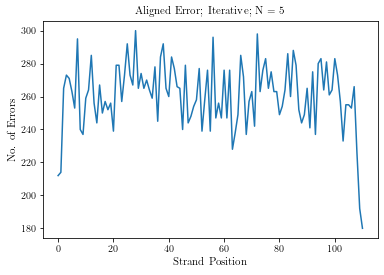

In [13]:
subs, counts = np.unique(pairs, return_counts=True, axis=0)
sorting = np.argsort(counts)
subs = subs[sorting]
counts = counts[sorting]

for sub, count in zip(subs, counts):
    if count > 5:
        print("{} -> {} @ {}".format(sub[0], sub[1], sub[2]), count)

strand_len = 110
pos_counts = [0] * (strand_len + 1)
for sub, count in zip(subs, counts):
    pos_counts[int(sub[2])] += count

print(pos_counts)

f = plt.figure()
plt.plot(range(strand_len + 1), pos_counts)
plt.title(r'Aligned Error; Iterative; N = 5', fontsize=11)
plt.xlabel(r'Strand Position', fontsize=11)
plt.ylabel(r'No. of Errors', fontsize=11)
plt.show()
f.savefig('cov5-iter-aligned.pdf', bbox_inches='tight')

In [14]:
subs, counts = np.unique(pairs, return_counts=True, axis=0)
sorting = np.argsort(counts)
subs = subs[sorting]
counts = counts[sorting]


In [15]:
def get_key(char1, char2):
    char1 = char1 if char1 != '' else '_'
    char2 = char2 if char2 != '' else '_'
    return char1 + ' -> ' + char2

strand_len = 110
pos_map = {}
pos_counts = [0] * (strand_len + 1)
for sub, count in zip(subs, counts):
    key = get_key(sub[0], sub[1])
    if key not in pos_map:
        pos_map[key] = [0] * (strand_len + 1)
    pos_map[key][int(sub[2])] += count

In [16]:
sub_keys = [get_key(sub[0], sub[1]) for sub in subs_no_pos]
max_10_keys = sub_keys[-10:]
max_10_counts = counts_no_pos[-10:]


[51, 36, 43, 41, 48, 40, 45, 50, 30, 37, 40, 42, 42, 39, 37, 41, 35, 44, 34, 38, 33, 49, 44, 32, 46, 56, 36, 39, 52, 37, 32, 42, 37, 44, 36, 43, 37, 33, 39, 55, 41, 50, 37, 49, 37, 32, 39, 49, 46, 50, 46, 48, 40, 31, 27, 31, 48, 38, 41, 30, 35, 40, 45, 42, 32, 39, 44, 51, 33, 42, 50, 35, 46, 23, 39, 40, 42, 52, 45, 46, 39, 31, 44, 45, 43, 41, 53, 41, 42, 38, 44, 31, 46, 34, 45, 43, 34, 50, 46, 47, 43, 45, 39, 34, 47, 47, 29, 47, 39, 27, 22]
[58, 39, 34, 48, 34, 48, 32, 51, 41, 36, 41, 42, 46, 45, 30, 43, 49, 44, 38, 44, 40, 44, 46, 36, 44, 54, 36, 46, 44, 47, 45, 38, 29, 33, 35, 49, 39, 50, 45, 30, 40, 42, 41, 44, 49, 50, 48, 31, 41, 31, 29, 46, 38, 29, 50, 37, 45, 43, 35, 54, 38, 44, 43, 25, 36, 39, 38, 42, 40, 38, 49, 45, 49, 49, 43, 38, 37, 43, 40, 44, 41, 33, 30, 49, 37, 41, 36, 38, 38, 37, 34, 47, 51, 31, 43, 38, 30, 39, 39, 31, 49, 47, 41, 31, 35, 45, 31, 28, 27, 30, 17]
[55, 35, 61, 48, 45, 35, 31, 43, 38, 33, 51, 48, 40, 35, 37, 47, 39, 35, 54, 49, 31, 38, 41, 39, 39, 47, 35, 4

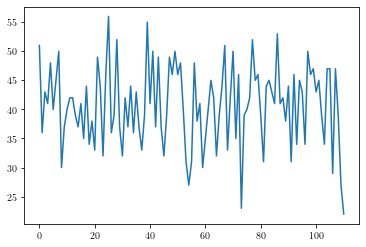

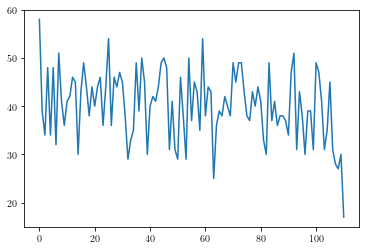

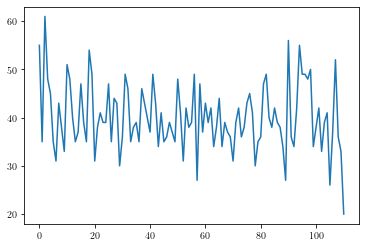

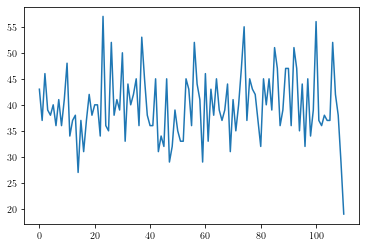

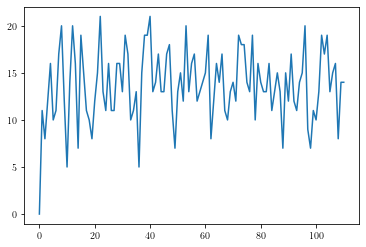

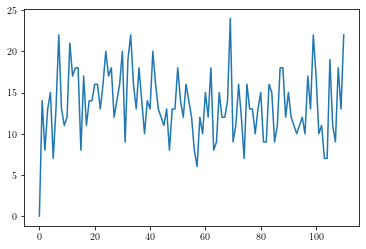

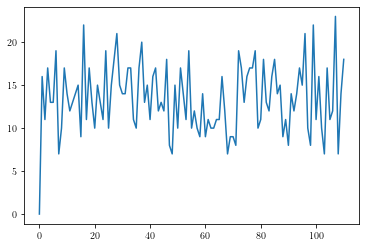

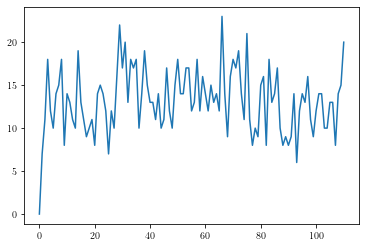

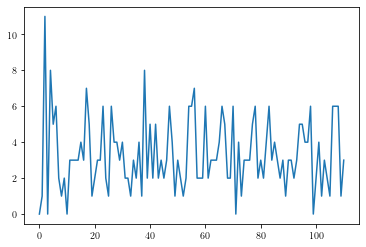

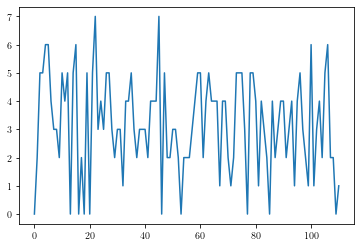

In [17]:
for key, count in zip(reversed(max_10_keys), reversed(max_10_counts)):
    plt.figure(key)
    print(pos_map[key])
    plt.plot(range(strand_len + 1), pos_map[key])

In [18]:
np.save('subs.npy', subs)
np.save('counts.npy', counts)